In [1]:
from tsfresh import extract_relevant_features
from tsfresh import extract_features
from tsfresh.utilities.dataframe_functions import impute
from tsfresh import select_features
from tsfresh.feature_selection.significance_tests import target_binary_feature_real_test
from tsfresh.feature_selection.relevance import calculate_relevance_table
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib notebook
from sys import stdout, stderr
from IPython.display import display, clear_output

<h1>Setting initial parameters, defining paths</h1>

In [2]:
# Set the initial parameters
dublin = False #False: Daphne, True: Dublin
signame = "breathing_rate"
# signame = "breathingSignal"
window = 10
pm = "pm2_5"

# Defining location of data
if dublin == True:
    res_data_path = ".\\Dublin raw data\\"
    combined_data_path = ".\\Speckled students\\Data\\Dublin\\2019-06-18 Dublin data\\"
    details_path = ".\\Speckled students\\Data\\Dublin\\"

    details_data = pd.read_csv(details_path + "participant_details_cleaned.csv")
    
    # Take only those subjects that had decreased fvc, fev1, pefr values
    subject_ids = details_data[details_data["baseline_fvc"] > details_data["post_exposure_fvc"]]
    subject_ids = subject_ids[subject_ids["baseline_fev1"] > subject_ids["post_exposure_fev1"]]
    subject_ids = subject_ids.loc[subject_ids["baseline_pefr"] > subject_ids["post_exposure_pefr"], "subj_id"].values   
    
    # Take 8 subjects which were manually selected as representative (matching locations of high pm values and indicated 
    # start and end of shs periods)
#     subject_ids = ["DBCA04", "DBCA05", "DBCA06", "DBCA15", "DBCC06", "DBCC08", "DBCC12", "DBCC15"]
#     subject_ids = details_data.loc[details_data["country"]=="Czech Rep", "subj_id"]
else:
    res_data_path = r".\Speckled students\Data\Daphne\Daphne raw data\\"
    combined_data_path = r".\Speckled students\Data\Daphne\2019-05-31 Daphne subject data\\"
    
    subject_ids = os.listdir(res_data_path)
    
    # Patients showing even slight positive or negative correlation between pm values and the breathing rate
#     subject_ids = ["DAP002(1)", "DAP008(1)", "DAP022(2)", "DAP046(1)", "DAP001(2)", "DAP006(1)", "DAP010(2)", "DAP033(1)", "DAP054(1)"]

# Overwriting the text display
last_stderr_length = 0
def stderr_overwrite(string):
    global last_stderr_length
    stderr.write("\r" +" "*last_stderr_length+"\r")
    stderr.write(string)


<h1>Preparing data for feature extraction/creating windows</h1>

In [3]:
# Taking manually defined intervals for shs and normal breathing for Dublln data
intervals_data = pd.read_csv(".\\Intervals.csv")

X = pd.DataFrame()
y = []
pm_full = []
pat = []
count = 0

for sub in subject_ids: 
    count += 1
    if dublin == False: sub = sub[:9]
    
    # If the breathing signal is set for Dublin data, then we take the the boundaries from the intervals_data file
    if signame != "breathing_rate" and dublin == True:
        
        # Reading in the raw RESpeck data
        res_data = pd.read_csv(res_data_path + sub + "_respeck_raw.csv")
        res_data["timestamp"] = pd.to_datetime(res_data["timestamp"])

        # From details file
        # Second-hand smoking periods
#         shs_period_start = pd.to_datetime(details_data.loc[details_data["subj_id"] == sub]["shs_period_start"]).values[0]
#         shs_period_end = pd.to_datetime(details_data.loc[details_data["subj_id"] == sub]["shs_period_end"]).values[0]
#         shs_period_start = np.where(res_data['timestamp'] > shs_period_start)[0][0]
#         shs_period_end = np.where(res_data['timestamp'] < shs_period_end)[0][-1]
        
        # From intervals file
        # Second-hand smoking periods
        shs_period_start = pd.to_datetime(intervals_data.loc[intervals_data["subj_id"] == sub]["shs_start_sample"]).values[0]
        shs_period_end = pd.to_datetime(intervals_data.loc[intervals_data["subj_id"] == sub]["shs_end_sample"]).values[0]
        shs_period_start = np.where(res_data['timestamp'] > shs_period_start)[0][0]
        shs_period_end = np.where(res_data['timestamp'] < shs_period_end)[0][-1]

         # Normal periods
        normal_period_start = pd.to_datetime(intervals_data.loc[intervals_data["subj_id"] == sub]["normal_start_sample"]).values[0]
        normal_period_end = pd.to_datetime(intervals_data.loc[intervals_data["subj_id"] == sub]["normal_end_sample"]).values[0]
        normal_period_start = np.where(res_data['timestamp'] > normal_period_start)[0][0]
        normal_period_end = np.where(res_data['timestamp'] < normal_period_end)[0][-1]


        # Removing everything except sitting/standing
        res_data.loc[res_data["activityType"] != 0, signame] = float('nan')
        
    # The breathing rate is set for any dataset
    elif signame == "breathing_rate":
        
        # Reading in the airspeck data
        air_data = pd.read_csv(combined_data_path + sub + "_airspeck_personal.csv")
        air_data["timestamp"] = pd.to_datetime(air_data["timestamp"])
        air_data = air_data[air_data[pm]>0]
#         air_data[pm] = (air_data[pm]-air_data[pm].min())/(air_data[pm].max()-air_data[pm].min()) * (3-0.4) + 0.4

         # Reading in the raw RESpeck data
        res_data = pd.read_csv(combined_data_path + sub + "_respeck.csv")
        res_data["timestamp"] = pd.to_datetime(res_data["timestamp"])
#         res_data[signame] = (res_data[signame]-res_data[signame].min())/(res_data[signame].max()-res_data[signame].min())
        
        # Merging
        res_data = res_data.merge(air_data, on='timestamp', how='inner')
        
        # Disregarding the upper 2% of the data (outliers)
        res_data = res_data[res_data[pm] < np.percentile(res_data[pm],98)].reset_index(drop=True)
    else:
        # If necessary, the methodology for this is implemented in file Dublin, Daphne analysis by visualizing the data, breath
        # detection.ipynb under section "Finding peaks and std to detect breathing"
        # Find the timestamps in the air_data which are between the start and end of the raw data, then take a mean of those pm values
        print("Asking for the breathing signal of Daphne data!")
        break
        
    # Taking windows
    i = 0
    while i < res_data.shape[0]-window:
        clear_output(wait=True)
        stderr_overwrite("Analyzing {} | {}/{}".format(sub, i+1, res_data.shape[0]))
        
        # Only considering non-nan intervals when teh eprson was not sleeping
        if (res_data[i:i+window][signame].isnull().any() == False and res_data.loc[i]["timestamp"].hour > 5):
            
            # Breathing signal, Dublin
            if signame != "breathing_rate":
                # Identifying SHS and signing the classes correspondingly
                if i > shs_period_start and i < shs_period_end:
    #                     y += [1]*60
                    y += [1]
                    pat += [sub] # patient id
                    signal = res_data[i:i+window]
                    signal['id'] = [count]*window # different id for each window
                    X = X.append(signal, ignore_index=True)
                    count += 1
                elif(i > normal_period_start and i < normal_period_end):
    #                     y += [0]*60
                    y += [0]
                    pat += [sub] # patient id
                    signal = res_data[i:i+window]
                    signal['id'] = [count]*window # different id for each window
                    X = X.append(signal, ignore_index=True)
                    count += 1
            else:
                # Checking whether the mean of pm values in a window are below or above some percentiles, ideitfying the classes correspondingly
                mean_pm = np.mean(res_data.loc[i:i+window, pm])
                if mean_pm > np.percentile(res_data[pm], 80):
                    signal = res_data[i:i+window]
                    signal['id'] = [count]*window # different id for each window
                    X = X.append(signal, ignore_index=True)
                    count += 1
                    pm_full += [mean_pm]
                    y += [1]
                    pat += [sub] # patient id
                if mean_pm < np.percentile(res_data[pm], 20):
                    signal = res_data[i:i+window]
                    signal['id'] = [count]*window # different id for each window
                    X = X.append(signal, ignore_index=True)
                    count += 1
                    pm_full += [mean_pm]
                    y += [0]
                    pat += [sub] # patient id
        i += window
        
       

Analyzing DAP001(2) | 421/2657

KeyboardInterrupt: 

<h1>Extracting the features, selecting the best ones and adding the class, pm values and subject ids for the best features found</h1>

In [16]:
X = X[['timestamp', 'id', signame]]
extracted_features = extract_features(X, column_id="id", column_sort="timestamp")
impute(extracted_features)
features_filtered = select_features(extracted_features, np.array(y), fdr_level=1)

# Adding columns (class, pm, subj_id) to the filtered best features dataframe
y = pd.Series(y)
y = y.rename('class')
pm_full = pd.Series(pm_full)
pm_full = pm_full.rename(pm)
pat = pd.Series(pat)
pat = pat.rename('subj_id')
features_filtered = features_filtered.reset_index(drop=True)
best_features = pd.concat([features_filtered, y], axis = 1)
best_features = pd.concat([best_features, pm_full], axis = 1)
best_features = pd.concat([best_features, pat], axis = 1)
# best_features.to_csv("filtered_ft_tsfresh_60.csv")

Feature Extraction: 100%|██████████████████████████████████████████████████████████████| 20/20 [00:36<00:00,  1.80s/it]
 'breathing_rate__agg_linear_trend__f_agg_"max"__chunk_len_10__attr_"rvalue"'
 'breathing_rate__agg_linear_trend__f_agg_"max"__chunk_len_10__attr_"slope"'
 'breathing_rate__agg_linear_trend__f_agg_"max"__chunk_len_10__attr_"stderr"'
 'breathing_rate__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"intercept"'
 'breathing_rate__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"rvalue"'
 'breathing_rate__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"slope"'
 'breathing_rate__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"stderr"'
 'breathing_rate__agg_linear_trend__f_agg_"mean"__chunk_len_10__attr_"intercept"'
 'breathing_rate__agg_linear_trend__f_agg_"mean"__chunk_len_10__attr_"rvalue"'
 'breathing_rate__agg_linear_trend__f_agg_"mean"__chunk_len_10__attr_"slope"'
 'breathing_rate__agg_linear_trend__f_agg_"mean"__chunk_len_10__attr_"stderr"'
 'breathing_rat

 'breathing_rate__spkt_welch_density__coeff_8'] did not have any finite values. Filling with zeros.


<h1>Finding best n features</h1>

In [4]:
table = calculate_relevance_table(extracted_features.reset_index(drop=True), y)
table = table.sort_values(by=['p_value'])
# table.to_csv("p_values.csv")
table = table[table['relevant']==True]
n_best = table.head(20)['feature'].values
print(n_best)

NameError: name 'extracted_features' is not defined

<h1>Plotting the best n features</h1>

Index(['breathing_rate__longest_strike_below_mean', 'breathing_rate__change_quantiles__f_agg_"mean"__isabs_True__qh_0.8__ql_0.6'], dtype='object', name='variable')


<IPython.core.display.Javascript object>


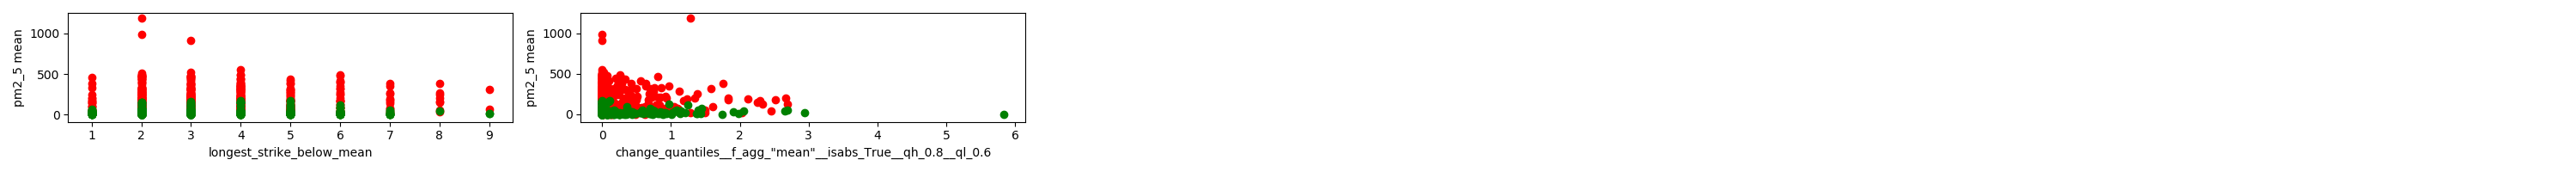

In [12]:
# n_best = features_filtered.columns
print(n_best)
plt.figure(88, figsize=(30, len(n_best)))
count = 0
for feat in n_best:
    good = best_features[best_features['class']==0]
    bad = best_features[best_features['class']==1]
    count += 1
    plt.subplot(round(len(n_best)/5)+1, 5, count)
    plt.scatter(bad[feat], bad[pm], c='r')
    plt.scatter(good[feat], good[pm], c='g')
    plt.xlabel(feat[len(signame)+2:])
    plt.ylabel(pm + " mean")
    plt.tight_layout()
# plt.savefig(r".\Analysis\Daphne\Scatter, daphne, breathing rate\20_80_percentiles_best_" + str(len(n_best)) +"_features_meanpm_window" + str(window) + "min.png")

<h1>The best n features with respect to each patient</h1>

<IPython.core.display.Javascript object>


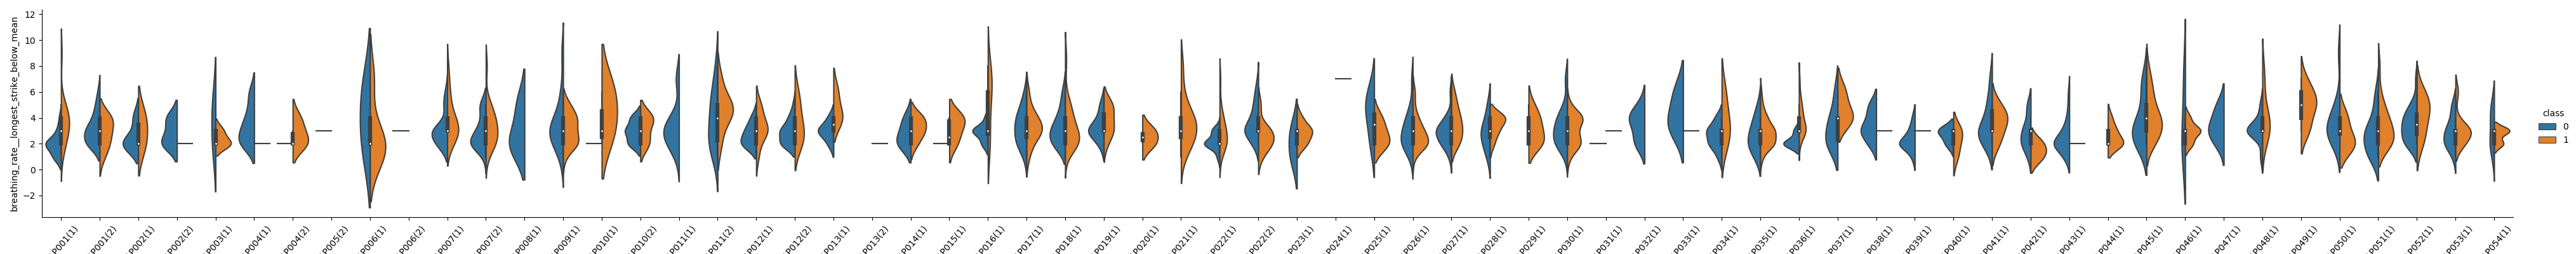

<IPython.core.display.Javascript object>


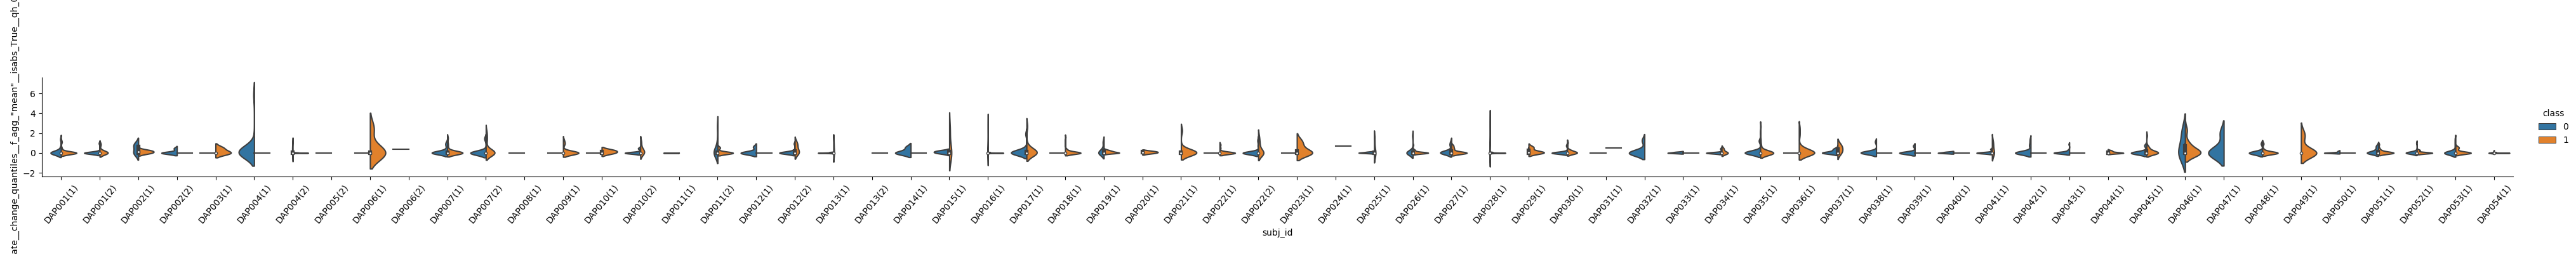

In [14]:
save_path = ".\\Analysis\\Daphne\\Violin plots, each patient, breathing rate, window 5, percentiles of 20, 80, mean pm\\"
good = best_features[best_features['class'] == 0]
bad = best_features[best_features['class'] == 1]
for feat in n_best:
    g = sns.catplot(x="subj_id", y=feat,
                     hue="class",
                     data=best_features, kind="violin", height=4, aspect=10, split=True);
    g.set_xticklabels(rotation=50)
    g.savefig(save_path + feat[len(signame)+2:len(signame)+20] + "window10.png")

<h1>Plotting all extracted features</h1>

<IPython.core.display.Javascript object>


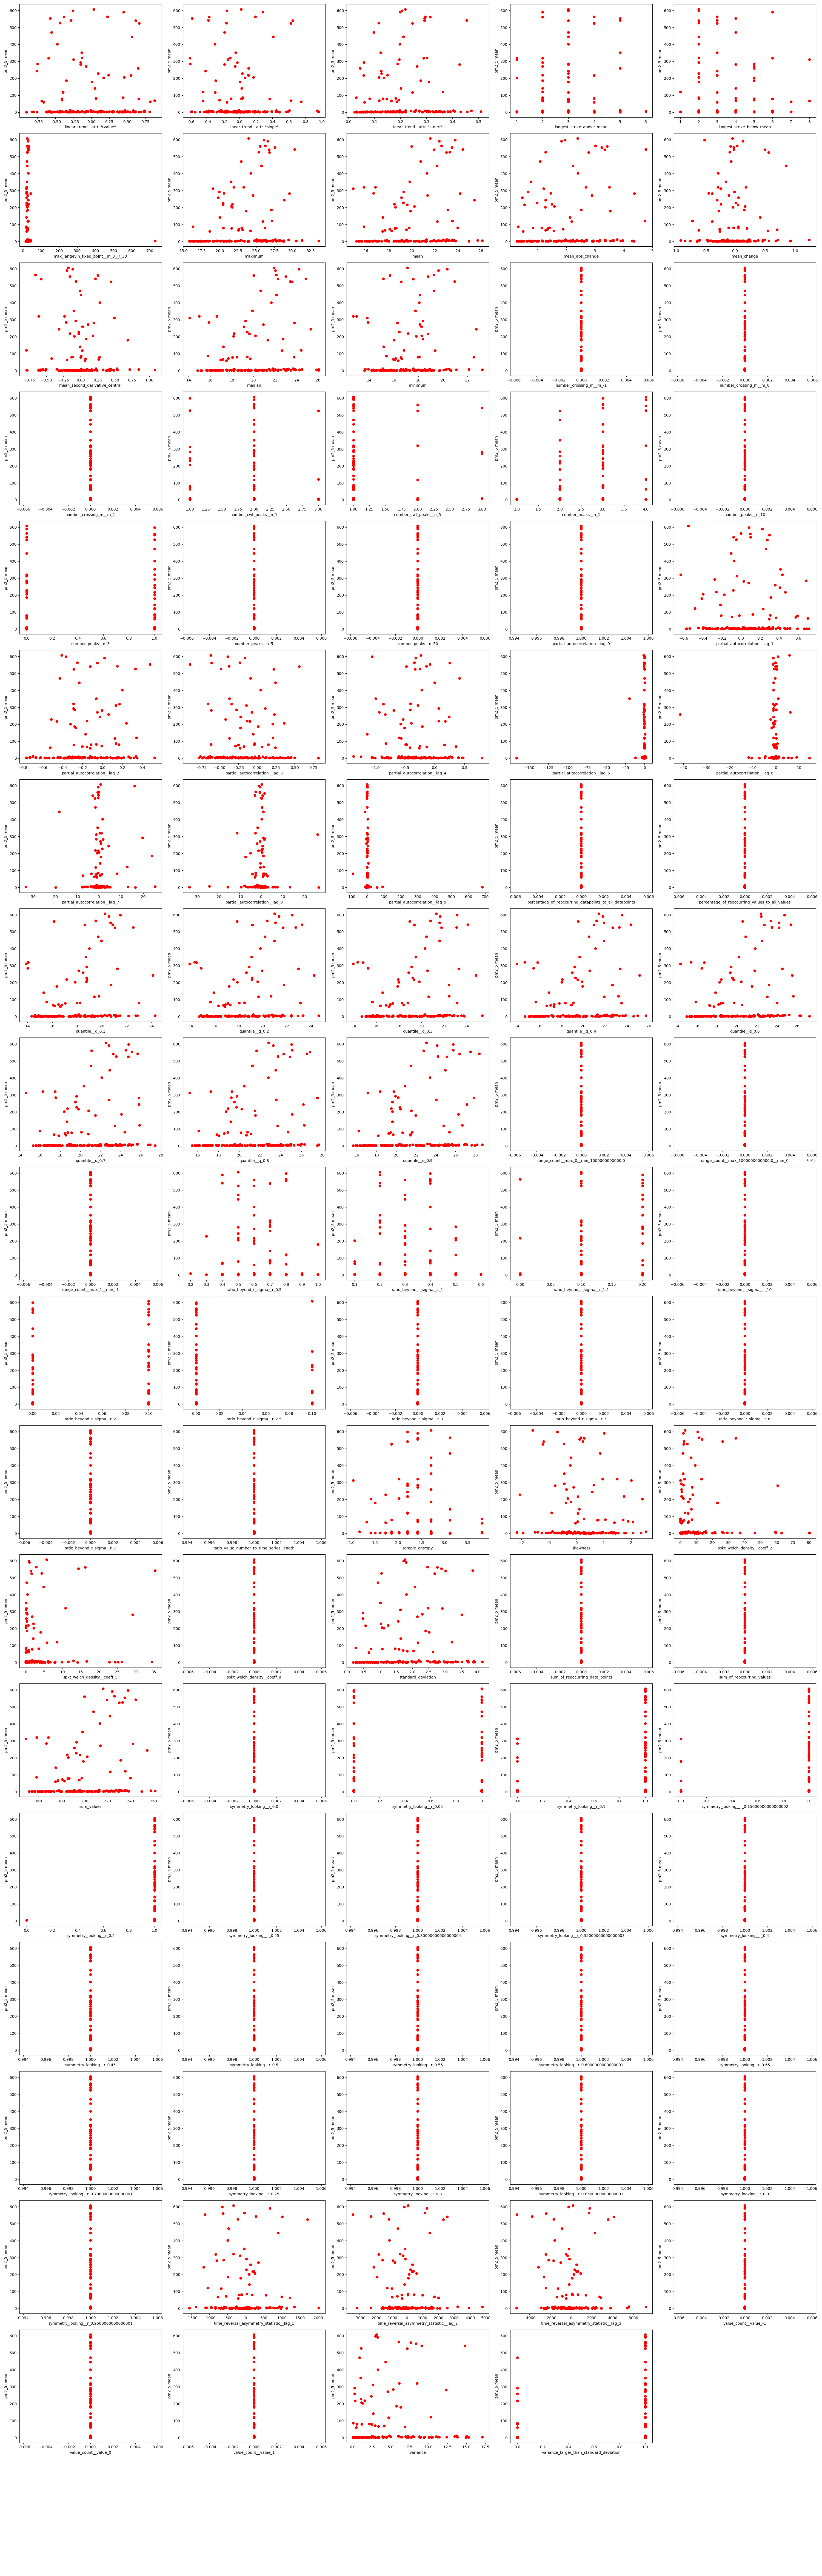

In [44]:
t = 0
w = 700
b = False
add = 100
while w <= len(extracted_features.columns):
    n_best = extracted_features.columns[w:w+add]
    plt.figure(12345+t, figsize=(30, len(n_best)))
    count = 0
    for feat in n_best:
    #     good = extracted_features[extracted_features['class']==0]
    #     bad = extracted_features[extracted_features['class']==1]
        count += 1
        plt.subplot(round(len(n_best)/5)+1, 5, count)
        plt.scatter(extracted_features[feat], pm_full, c='r')
        plt.xlabel(feat[len(signame)+2:])
        plt.ylabel(pm + " mean")
        plt.tight_layout()
#     plt.savefig(r".\Analysis\Scatter, daphne, breathing rate\\best_" + str(len(n_best)) +"_features_meanpm_window" + str(window) + "min" + "_" + str(w) +".png")
    t += 1
    w += 100
    if w > len(extracted_features.columns) and b == False:
        add = len(extracted_features.columns)-w
        b = True